In [1]:
import autograd.numpy as np
import numpy
from autograd import jacobian
import scipy.optimize as sciopt
from scipy import interpolate
from tqdm import tqdm_notebook
import matplotlib.pyplot as plt

![diagram](diagram.png)

### Install prerequisites

In [ ]:
!pip install autograd
!pip install tqdm

azure-mgmt 4.0.0 has requirement azure-mgmt-storage~=2.0, but you'll have azure-mgmt-storage 3.1.0 which is incompatible.
You are using pip version 18.1, however version 19.0.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


[ 0.39269908 -0.39269908  0.39269908 -0.39269908]
[-0.38268343 -2.7716386 ]
constraint: 0.0
(array([ 1.69309011e-14, -3.82683432e-01, -0.00000000e+00,  3.82683432e-01,
        2.21489493e-14, -3.82683432e-01]), array([-1.84775907, -0.92387953, -0.        , -0.92387953, -1.84775907,
       -2.7716386 ]))


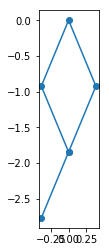

In [28]:
# Lengths of the links
d = [1., 1, 1., 1, 2]
vec = lambda d,θ: d*np.exp(θ*1j)

def kinematic_chain(θ, d=d):
    ''' Should equal 0 at solution 
    '''
    θ1, θ2, θ3, θ4 = θ
    d1, d2, d3, d4, _ = d
    return -vec(d1,θ1) + vec(d2,θ2) + vec(d3,θ3) - vec(d4,θ4) 

def kinematic_constraint(θ, d=d):
    _, θ2, θ3, θ4 = θ
    _, d2, d3, d4, _ = d
    
    l1 = vec(d2,θ2) + 0.5*(vec(d3,θ3) - vec(d4,θ4))
    l2 = vec(d2,θ2) + vec(d3,θ3)
    
    dist = np.maximum(0. , np.linalg.norm(l1) - np.linalg.norm(l2))
    return dist

def kinematic_endpoint(θ, d=d):
    ''' Computes the location of the end of the arm 
    '''
    _, θ2, θ3, _ = θ
    _, d2, d3, _, d5 = d
    r = vec(d2,θ2) + vec(d5,θ3)
    
    return np.array([-np.imag(r), -np.real(r)])

def make_f(θ1, θ2):
    ''' Returns function to pass to optimize.root 
    '''
    def f(θ):
        θ3, θ4 = θ
        r = kinematic_chain([θ1, θ2, θ3, θ4])
        dist = kinematic_constraint([θ1, θ2, θ3, θ4])
        return np.array([np.real(r), np.imag(r)])
    
    return f

def solve_chain(θ1, θ2, x0=np.array([0.,0.])):
    ''' Solves for θ3, θ4 given θ1, θ2 
        TODO: check feasibility. Solution is not unique 
    '''
    _f = make_f(θ1, θ2)
    _jac = jacobian(_f)
    sol = sciopt.root(_f, x0, jac=_jac)
    
    return sol.x

def wireframe(θ, d=d):
    θ1, θ2, θ3, θ4 = θ
    d1, d2, d3, d4, d5 = d
    r1, r2, r3, r4, r5 = vec(d1,θ1), vec(d2,θ2), vec(d3,θ3), vec(d4,θ4), vec(d5-d3,θ3)
    pts = np.array([r1+r4, r1, 0, r2, r2+r3, r2+r3+r5])
    return  -np.imag(pts), -np.real(pts)

def tests():
    _θ1, _θ2 = np.pi/8, -np.pi/8
    while True:
        x0 = np.random.uniform(0,2*np.pi,2)
        _θ3, _θ4 = solve_chain(_θ1, _θ2, x0=x0)

        _θ = np.array([_θ1, _θ2, _θ3, _θ4])
        kc = kinematic_constraint(_θ)
        ke = kinematic_endpoint(_θ)
    
        wf = wireframe(_θ)
        print(_θ)
        print(ke)
        print("constraint:", kc)
        print(wf)
        plt.plot(*wf, 'o-')
        plt.gca().set_aspect('equal')
        
        if kc == 0.:
            break
    
tests()


In [78]:
def compute_mapping(c = np.pi/2, num=25):
    ''' Computes mapping from (θ1, θ2) to (x,y) 
    '''
    
    theta = []
    endpoint = []
    
    θ3,θ4 = 0.,0.
    for θ2 in tqdm_notebook(np.linspace(-c, c, num)[:-2]):
        for θ1 in np.linspace(θ2, c, num)[1:]:
            for _ in range(1000):
                x0 = np.random.uniform(0,2*np.pi,2)
                θ3, θ4 = solve_chain(θ1, θ2, x0=x0)
                if kinematic_constraint([θ1, θ2, θ3, θ4]) == 0.:
                    break
            else:
                print('failed')
            
            _θ = np.array([θ1, θ2, θ3, θ4])
            xy = kinematic_endpoint(_θ)
            wf = wireframe(_θ)

            theta.append(_θ)
            endpoint.append(xy)
#             plt.figure()
#             plt.plot(*wf, 'o-')
#             plt.gca().set_aspect('equal')

#             plt.show()


    _input = np.array(theta)
    _output = np.array(endpoint).reshape((len(endpoint), 2))
    return _input, _output    

theta, xy = compute_mapping(num=100)

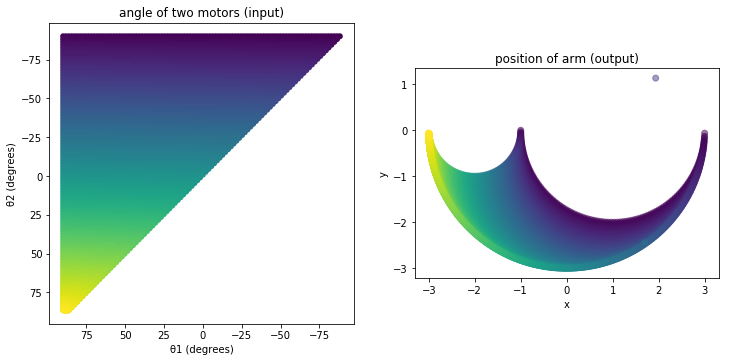

In [79]:
def plot_mapping(theta, xy, points=None):
    plt.figure(figsize=(12,23))
    plt.subplot(1,2,1)
    plt.scatter(*theta[:,:2].T*180/np.pi, c=np.linspace(0,1,len(theta)), linewidth=0)
    if points is not None: plt.scatter(*theta[points,:2].T*180/np.pi, c=np.linspace(0,1,len(points)), cmap='gray', s=10)
    plt.gca().invert_xaxis()
    plt.gca().invert_yaxis()
    plt.xlabel('θ1 (degrees)')
    plt.ylabel('θ2 (degrees)')
    plt.gca().set_aspect('equal')
    plt.title('angle of two motors (input)')


    plt.subplot(1,2,2)
    plt.scatter(*xy.T,c=np.linspace(0,1,len(theta)), alpha=0.5)
    if points is not None: plt.scatter(*xy[points].T, c=np.linspace(0,1,len(points)), cmap='gray', s=3)
    plt.xlabel('x')
    plt.ylabel('y')
    plt.gca().set_aspect('equal')
    plt.title('position of arm (output)')
    plt.show()
    
plot_mapping(theta, xy)

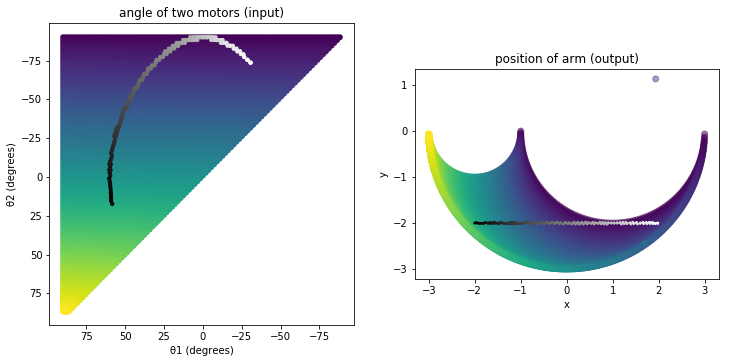

In [80]:
_n = 200
x = np.linspace(-2,2,_n)
y = np.linspace(-2,-2,_n)

desired = np.vstack([x,y]).T
dist = np.linalg.norm(xy - desired[:,np.newaxis],axis=2)
points = np.argmin(dist,axis=1)

plot_mapping(theta, xy, points)

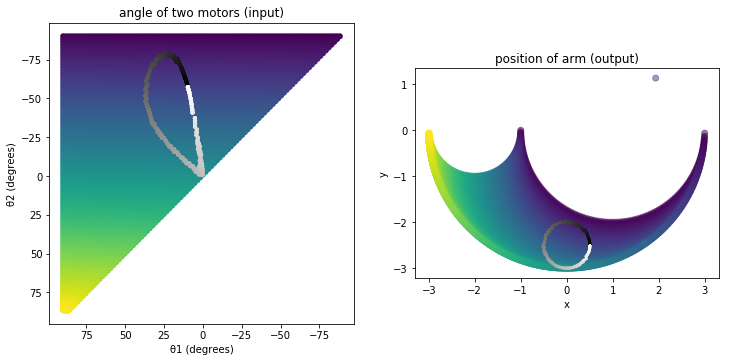

In [81]:
_n = 500
_t = np.linspace(0,2*np.pi,_n)
_r = 0.5
_c = np.array([0,-2.5])
x = _r*np.cos(_t) + _c[0]
y = _r*np.sin(_t) + _c[1]

desired = np.vstack([x,y]).T
dist = np.linalg.norm(xy - desired[:,np.newaxis],axis=2)
points = np.argmin(dist,axis=1)

plot_mapping(theta, xy, points)

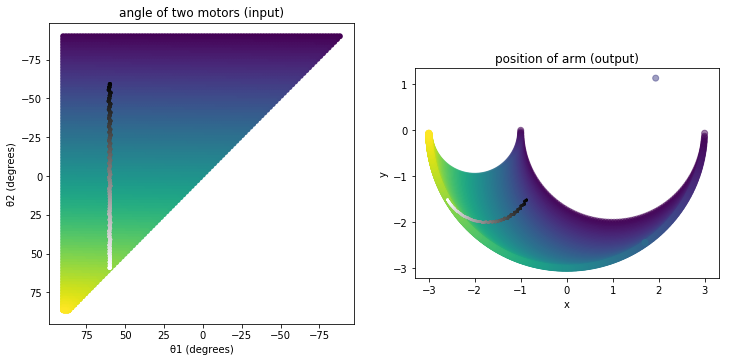

In [83]:
_n = 200
t = np.linspace(-np.pi/3, np.pi/3, _n)
desired = np.vstack([0*t+np.pi/3, t]).T
dist = np.linalg.norm(theta[:,:2] - desired[:,np.newaxis],axis=2)
points = np.argmin(dist,axis=1)

plot_mapping(theta, xy, points)


In [75]:
theta

array([[-1.53906307, -1.57079633],
       [-1.50732981, -1.57079633],
       [-1.47559655, -1.57079633],
       ...,
       [ 1.57079633,  1.57079633],
       [ 1.57079633,  1.57079633],
       [ 1.57079633,  1.57079633]])

In [74]:
plt.scatter(*theta[:,2:].T)

TypeError: scatter() missing 2 required positional arguments: 'x' and 'y'

In [ ]:
_n = 200
x, y = numpy.mgrid[-1.2:1:25j, -2.8:-2:25j]
x,y  = x.ravel(), y.ravel()

desired = np.vstack([x,y]).T
dist = np.linalg.norm(xy - desired[:,np.newaxis],axis=2)
points = np.argmin(dist,axis=1)

plot_mapping(theta, xy, points)



In [84]:
x_interp = interpolate.interp2d(theta[:,0], theta[:,1], xy[:,0])
y_interp = interpolate.interp2d(theta[:,0], theta[:,1], xy[:,1])

θ1_interp = interpolate.interp2d(xy[:,0], xy[:,1], theta[:,0])
θ2_interp = interpolate.interp2d(xy[:,0], xy[:,1], theta[:,1])

/Users/ben/anaconda3/lib/python3.5/site-packages/scipy/interpolate/_fitpack_impl.py:976: RuntimeWarning: No more knots can be added because the number of B-spline
coefficients already exceeds the number of data points m.
Probable causes: either s or m too small. (fp>s)
	kx,ky=1,1 nx,ny=120,85 m=9702 fp=0.000007 s=0.000000
  warnings.warn(RuntimeWarning(_iermess2[ierm][0] + _mess))
/Users/ben/anaconda3/lib/python3.5/site-packages/scipy/interpolate/_fitpack_impl.py:976: RuntimeWarning: No more knots can be added because the number of B-spline
coefficients already exceeds the number of data points m.
Probable causes: either s or m too small. (fp>s)
	kx,ky=1,1 nx,ny=114,89 m=9702 fp=0.000008 s=0.000000
  warnings.warn(RuntimeWarning(_iermess2[ierm][0] + _mess))
/Users/ben/anaconda3/lib/python3.5/site-packages/scipy/interpolate/_fitpack_impl.py:976: RuntimeWarning: No more knots can be added because the number of B-spline
coefficients already exceeds the number of data points m.
Probable ca